# Optimal Estimation Forward Model

David R. Thompson, Jet Propulsion Laboratory, California Institute of Technology<br>
Contact: david.r.thompson@jpl.nasa.gov
__________

The purpose of this exercise is to explore the use of Optimal Estimation methods for the purpose of atmospheric correction in VSWIR imaging spectrometer data.  It presumes a familiarity with Rodgers optimal estimation concepts (priors and posteriors, averaging kernels, gain matrices, etc.) and will focus on the specifics as they relate to imaging spectroscopy and surface property retrieval.  

First, we import our dependencies. You may want to replace the filepaths below with your own installation of ISOFIT.

In [1]:
import sys, os
import scipy as s
import pylab as plt

sys.path.insert(0, "../isofit")
from isofit.instrument import Instrument
from isofit.rt_modtran import ModtranRT
from isofit.geometry import Geometry
from isofit.surf_multicomp import MultiComponentSurface 
from isofit.forward import ForwardModel
from isofit.inverse import Inversion

import figure_style

First, we define the instrument consisting of a spectral calibration and noise model. The wavelengths file contains both channel centers and the FWHM of Gaussian spectral response functions. The noise file defines a signal- and channel-dependent parametric description.

In [2]:
instrument_config = {
    "wavelength_file": "data/wavelengths.txt",
    "integrations": 1,
    "parametric_noise_file": "data/avirisng_noise.txt",
    "unknowns": {
        "cal_uncertainty_systematic_file": "../data/avirisng_systematic_error.txt",
        "cal_uncertainty_flatfield": 0.01
    }
}

avirisng = Instrument(instrument_config) 

Let's plot the radiance of Beckman Lawn from the actual flight data.

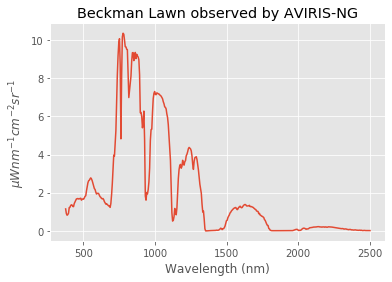

In [3]:
# Load data, transpose, and plot
wavelengths, radiance = s.loadtxt('data/beckmanlawn_radiance.txt').T
plt.plot(wavelengths, radiance)
plt.xlabel('Wavelength (nm)')
plt.ylabel('$\mu{W} nm^{-1} cm^{-2} sr^{-1}$')
plt.title('Beckman Lawn observed by AVIRIS-NG');

The instrument noise is signal dependent, but we can use our instrument model to figure out what the instrument noise looks like for this particular radiance.  The `Sy()` function gives us a full covariance matrix, but we'll plot the standard deviation based on diagonal elements.

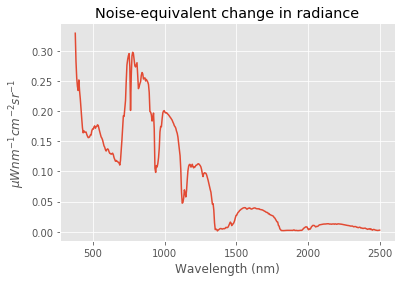

In [4]:
# Plot the standard deviation
Sy = avirisng.Sy(radiance*100.0, geom=None)
NEdL = s.sqrt(s.diag(Sy))
plt.plot(wavelengths, NEdL)
plt.xlabel('Wavelength (nm)')
plt.ylabel('$\mu W nm^{-1} cm^{-2} sr^{-1}$')
plt.title('Noise-equivalent change in radiance');

**Question 1:** How does noise change as you scale the radiance?  For which wavelengths is noise most dependent on signal level? Do you have a hypothesis to explain why this is the case?

In [6]:
rtm_config = {
    "lut_path":"data/lut/",
    "wavelength_file": "data/wavelengths.txt",
    "modtran_template_file":"data/modtran.json",
    "domain": {"start": 350, "end": 2520, "step": 0.1},
    "statevector": {
        "H2OSTR": {
            "bounds": [1.5, 2.0],
            "scale": 0.01,
            "init": 1.75,
            "prior_mean": 1.75,
            "prior_sigma": 2.0
        },
        "AOT550": {
            "bounds": [0.01, 0.1],
            "scale": 0.01,
            "init": 0.05,
            "prior_mean": 0.05,
            "prior_sigma": 0.1
        }
    },
    "lut_grid": {
        "H2OSTR": [1.5, 2.0],
        "AOT550": [0.01, 0.1]
    },
    "unknowns": {
        "H2O_ABSCO": 0.01
    },
    "auto_rebuild":False
}

rtm = ModtranRT(rtm_config)

We begin with a measurement $\mathbf{y}$ that has already been spectrally calibrated and transformed to radiance ($\mu$W nm$^{-1}$ sr$^{-1}$ cm$^{-2}$).  We write the measured radiance in each wavelength as $\mathbf{L}_{obs} = [\ell_{\lambda 1},\dots,\ell_{\lambda m}]^T$. For convenience we normalize solar illumination by transforming to the apparent top of atmosphere reflectance, $\mathbf{\rho}_{\rm toa}$, for solar downward irradiance $\mathbf{f}$ at the top of the atmosphere, with a factor $\phi_0$ representing the cosine of the solar zenith angle.  For a Lambertian surface this further decomposes into a path reflectance $\mathbf{\rho}_a$, a spherical albedo $\mathbf{s}$, atmospheric transmission $\mathbf{t}$, and the surface reflectance $\mathbf{\rho}_s$.  They are related by the following expression in which $\circ$ signifies element-wise multiplication [Thompson et al., RSE 2018]: 

$\mathbf{\rho}_{\rm toa}  = \frac{\mathbf{L}_{obs}\pi}{\phi_0\mathbf{f}} =  \mathbf{\rho}_a +\frac{\mathbf{t}\circ \mathbf{\rho}_s}{1-(\mathbf{s} \circ \mathbf{\rho}_s)}$

For a given atmosphere and observing geometry, one can calculate $\mathbf{t}$, $\mathbf{s}$, and $\mathbf{\rho}_a$ using our RTM.  By convention, the atmospheric state vector has the same order given in our configuration (H$_2$O first). We can specify any value in our interpolation range (1.5 - 2.0 g cm$^{-2}$ H$_2$O and AOT550 = 0.01-0.1)

First, we define a generic observation geometry. Most of the geometry we care about is already baked in to the RTM results.

In [7]:
# Define observation geometry
geom = Geometry()

Now, we can calculate optical coefficients via multilinear interpolation from the cached RTM results:

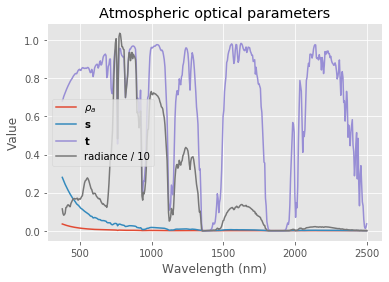

In [8]:
# Optical coefficients via multilinear interpolation
aod550 = 0.05
h2o = 1.75
wavelengths = rtm.wl
atm_state = s.array([h2o, aod550])

# Run the RTM
rhoa, sp, t, tup = rtm.get(atm_state, geom)

# Plot
plt.plot(wavelengths, rhoa)
plt.plot(wavelengths, sp)
plt.plot(wavelengths, t)
plt.plot(wavelengths, radiance*0.1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Value')
plt.title('Atmospheric optical parameters')
plt.legend([r'${\rho}_a$',r'$\mathbf{s}$',r'$\mathbf{t}$','radiance / 10']);

**Question 2:** How do these optical properties change with differences in H$_2$O? Aerosols? Why?  

We'll define the surface prior as a collection of multivariate Gaussians. This surface model contains components to handle vegetated and non-vegetated surfaces.  It is fairly highly regularized, so it can be used to retrieve novel surface shapes that are not expected.

In [9]:
# Define surface geometry
surface_config = {
    "surface_file": "data/surface.mat"
}

lawn = MultiComponentSurface(surface_config)

../isofit/isofit/common.py:163: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "svd_inv" failed type inference due to: Invalid use of type(CPUDispatcher(<function svd_inv_sqrt at 0x1c22e95950>)) with parameters (array(float64, 2d, C), int64, none)
 * parameterized
[1] During: resolving callee type: type(CPUDispatcher(<function svd_inv_sqrt at 0x1c22e95950>))
[2] During: typing of call at ../isofit/isofit/common.py (167)


File "../isofit/isofit/common.py", line 167:
def svd_inv(C, mineig=0, hashtable=None):
    <source elided>

    return svd_inv_sqrt(C, mineig, hashtable)[0]
    ^

  @jit
/Users/americks/anaconda3/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "svd_inv" was compiled in object mode without forceobj=True.

File "../isofit/isofit/common.py", line 164:
@jit
def svd_inv(C, mineig=0, hashtable=None):
^

  self.func_ir.loc))
/Users/americks/anaconda3/lib/python3.7/site-packages/numba/compiler.py:

Let's take a look at the means of the component Gaussians in our surface priors. These are held in the list `lawn.mus`.

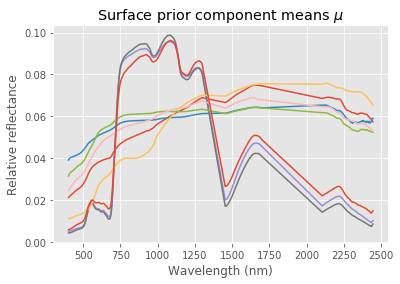

In [10]:
# Plot the means of the component Gaussians
means = lawn.mus
wavelengths = lawn.refwl

for mu in means:
    plt.plot(wavelengths, mu)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Relative reflectance')
plt.title('Surface prior component means $\mu$');

ISOFIT lets us define a concise forward model that ties the component Gaussians together.  

In [11]:
# Define the forward model
fm_params = {
    "instrument": instrument_config,
    "multicomponent_surface": surface_config,
    "modtran_radiative_transfer": rtm_config
}

fm = ForwardModel(fm_params)

../isofit/isofit/rt_lut.py:165: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rhoatm[ind] = rhoatm
../isofit/isofit/rt_lut.py:166: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.sphalb[ind] = sphalb
../isofit/isofit/rt_lut.py:167: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.transm[ind] = transm
../i

Let's predict some radiances using generic uniform surface reflectances. By convention, our state vector for the forward model consists of one reflectance value for every channel, followed by the atmospheric parameters.

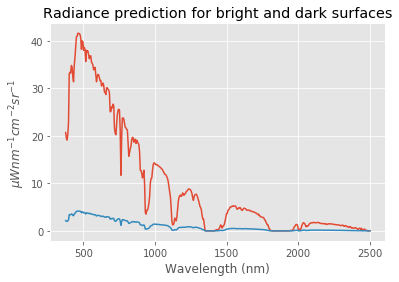

In [12]:
# Atmospheric state
h2o_column = 1.7
aod550 = 0.1

atm_state = s.array([1.7, 0.01])
wavelengths = lawn.wl.copy()

# Get radiances
bright_reflectance = s.ones(len(wavelengths))
bright_statevector = s.concatenate((bright_reflectance, atm_state))
bright_radiance_prediction = fm.calc_rdn(bright_statevector, geom)

# Plot
plt.plot(wavelengths, bright_radiance_prediction)

# Get dark radiance
dark_reflectance = bright_reflectance * 0.1
dark_statevector = s.concatenate((dark_reflectance, atm_state))
dark_radiance_prediction = fm.calc_rdn(dark_statevector, geom)

plt.plot(wavelengths, dark_radiance_prediction)
plt.xlabel('Wavelength (nm)')#the forward model consists of one reflectance value in every channel, followed by the atmospheric parameters.)')
plt.ylabel('$\mu W nm^{-1} cm^{-2} sr^{-1}$')
plt.title('Radiance prediction for bright and dark surfaces');


**Question 3:** Based on the radiance spectrum we observed above and comparing with different predictions from our RTM, what do you think the average reflectance of the Beckman Lawn is at 500 nm? at 1000 nm?

-------------
<b>Acknowledgements</b>: A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. We acknowledge the support of a PRISM AITT grant from the National Aeronautics and Space Administration (NASA) Earth Science Technology Office. We acknowledge the support of the JPL and Caltech Presidents’ and Directors’ Fund Program. We thank other supporting sponsors including the NASA Earth Science Division for the HyspIRI preparatory campaign, the AVIRIS-NG instrument and the data analysis program “Utilization of Airborne Visible/Infrared Imaging Spectrometer Next Generation Data from an Airborne Campaign in India” NNH16ZDA001N-AVRSNG, for its support of the algorithm development; the Jet Propulsion Laboratory Research and Technology Development Program; and the NASA Center Innovation Fund managed in conjunction with the Jet Propulsion Laboratory Office of the Chief Scientist and Technologist. Copyright 2019 California Institute of Technology. US Government Support Acknowledged.